In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

# sns.set(font_scale=1.6, palette='summer')
sns.set(font_scale=1.6, palette='Set2')


%matplotlib inline

from sklearn.metrics import recall_score, accuracy_score, precision_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression as skRegression
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets import  make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import Ridge, Lasso, ElasticNet

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE, mean_absolute_percentage_error as MAPE
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm
from sklearn.datasets import load_svmlight_file
import time
import keras
from keras.datasets import fashion_mnist

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.datasets import make_circles
from sklearn.kernel_approximation import Nystroem
from sklearn.metrics import precision_recall_curve

In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all warnings
simplefilter(action='ignore')

***Мотивация метода***
Самые эффективные с точки зрения временных затрат и хорошо интерпретируемые методы классификации - линейные, например логистическая регрессия или SVM. \
В практических задачах машинного обучения предположение о линейной зависимости признаков зачастую оказывается неверным. Оказывается, в таких ситуациях иногда может помочь переход к другому пространству признаков. \
Проиллюстрируем это.

In [3]:
X_circles, y_circles = make_circles(n_samples = 2000, noise = 0.1)

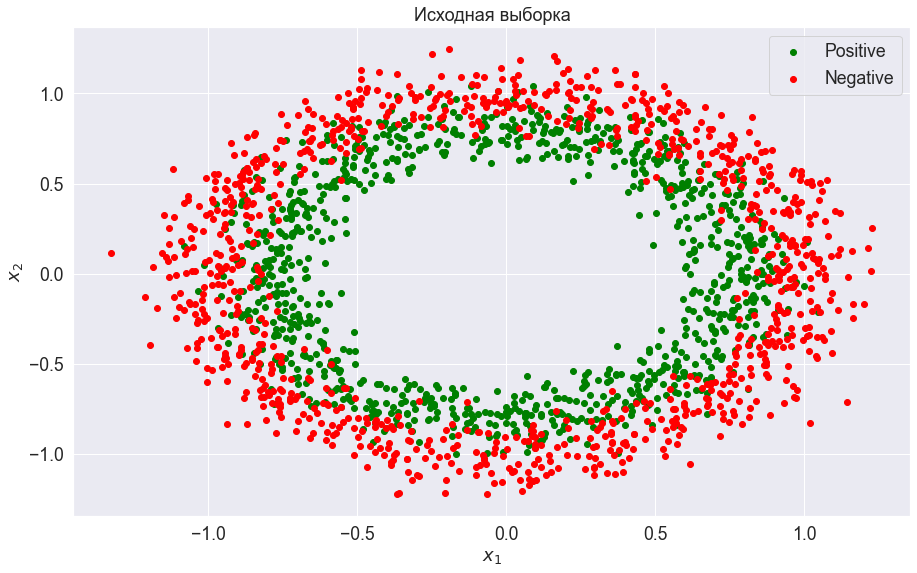

In [4]:
fig = plt.figure(figsize=(15, 9))
pos = (y_circles == 1)
neg = (y_circles != 1)
plt.scatter(X_circles[pos, 0], X_circles[pos, 1], c='g', label='Positive')
plt.scatter(X_circles[neg, 0], X_circles[neg, 1], c='r', label='Negative')
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18)
plt.title('Исходная выборка', fontsize=18)
plt.legend()
plt.show()

Видим, что приблизить спрямляющее пространство гиперплоскостью(прямой) почти невозможно. \
Теперь добавим новый параметр: $x_3 = x_1^2 + x_2^2$

In [5]:
X_tricked = np.vstack([X_circles[:, 0], X_circles[:, 1], X_circles[:, 0] ** 2 + X_circles[:, 1] ** 2]).T

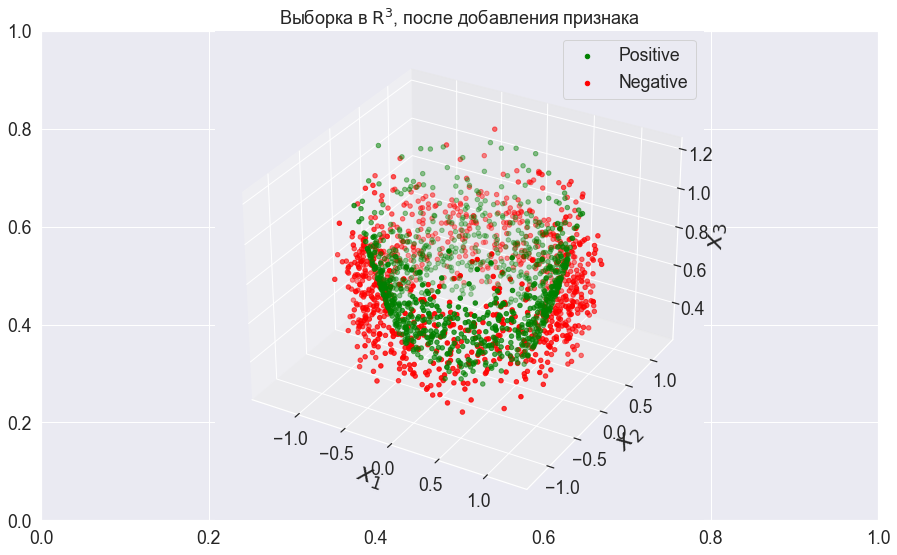

In [6]:
fig = plt.figure(figsize=(15, 9))
ax = plt.gca()
pos = (y_circles == 1)
neg = (y_circles != 1)
ax = fig.add_subplot(projection='3d')
ax.set_zlabel('$x_3$', fontsize=25)
ax.scatter(X_tricked[pos, 0], X_tricked[pos, 1], X_tricked[pos, 2], c='g', label='Positive')
ax.scatter(X_tricked[neg, 0], X_tricked[neg, 1], X_tricked[pos, 2], c='r', label='Negative')
ax.set_xlabel('$x_1$', fontsize=25)
ax.set_ylabel('$x_2$', fontsize=25)
ax.set_title('Выборка в $\\mathsf{R}^3$, после добавления признака', fontsize=18)
ax.legend()
plt.show()

Мало что понятно, построим графики проекций.

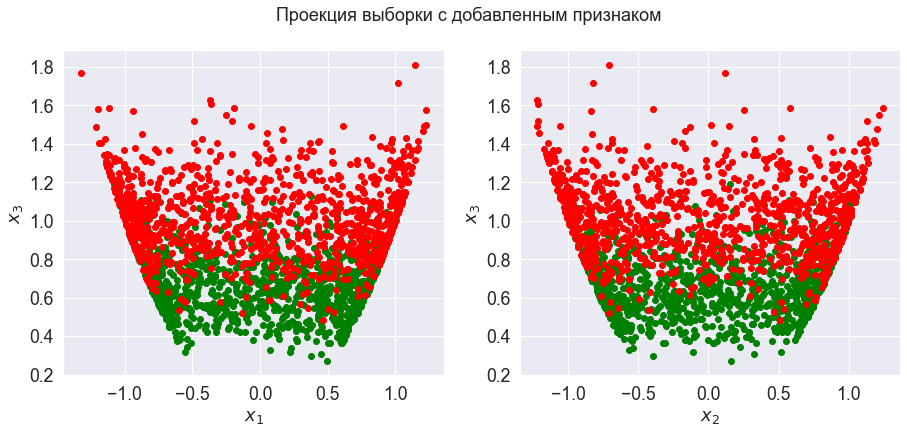

In [7]:
plt.figure(figsize=(15, 6))

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.scatter(X_tricked[pos, i], X_tricked[pos, 2], c='g', label='Positive')
    plt.scatter(X_tricked[neg, i], X_tricked[neg, 2], c='r', label='Negative')
    plt.xlabel(f'$x_{i+1}$', fontsize=18)
    plt.ylabel('$x_3$', fontsize=18)
plt.suptitle('Проекция выборки с добавленным признаком', fontsize=18)
plt.show()

Теперь отчетливо видно, что разделяющее пространство отлично приближается гиперплоскостью $x_3 = C$.

Мы убедились, что изменение пространства признаков может позволить применить линейные методы классификации.\
Встает вопрос, как именно это делать. И правда, хочется взять как можно больше базисных нелинейных функций от исходных признаков, но тогда значительно вырастет время обучения и предсказания модели.

***Подход к построению новых признаков***
$\newcommand{\norm}[1]{\left\lVert#1\right\rVert}$ \
Для примера рассмотрим задачу Ridge-регрессии:\
$Q(\theta) = \norm{X\theta - y}^2 + \lambda \norm{\theta}^2 \rightarrow \min$ \
Дифференцируем и получаем, что \
$\theta = \dfrac{-1}{\lambda}X^T(X\theta - y)$ \
$\theta = X^T a$, где $a = \dfrac{-1}{\lambda}(X\theta - y)$ \
$Q(a) = \norm{X^TXa - y}^2 + \lambda a^TX^TXa  \rightarrow \min$ \
Видим, что теперь функционал зависит лишь от матрицы Грама, а не от исходной матрицы. 


***Теперь рассмотрим задачу классификации*** \
Построим к методу опорных векторов(SVM) двойственную:\
$\begin{cases} \sum\limits_{i=1}^d \lambda_i - \dfrac{1}{2}\sum\limits_{i, j=1}^d \lambda_i \lambda_j y_i y_j\langle x_i, x_j \rangle \rightarrow \max_{\lambda} \\ 0 \leq \lambda_i \leq C \\ \sum\limits_{i=1}^d \lambda_i y_i = 0 \end{cases}$ \
Снова видим, что функционал зависит лишь от матрицы Грама. 

Это все наводит нас на идею, что можно обобщить скалярное произведение, перейдя в другое пространство. \
Таким образом, вместо скалярного произведения $\langle x_i, x_j \rangle$ будем использовать ядро $K(x_i, x_j)$. 

Дальше нас соответственно интересует сам анализ работы линейных методов при различных ядерных функциях.

In [8]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

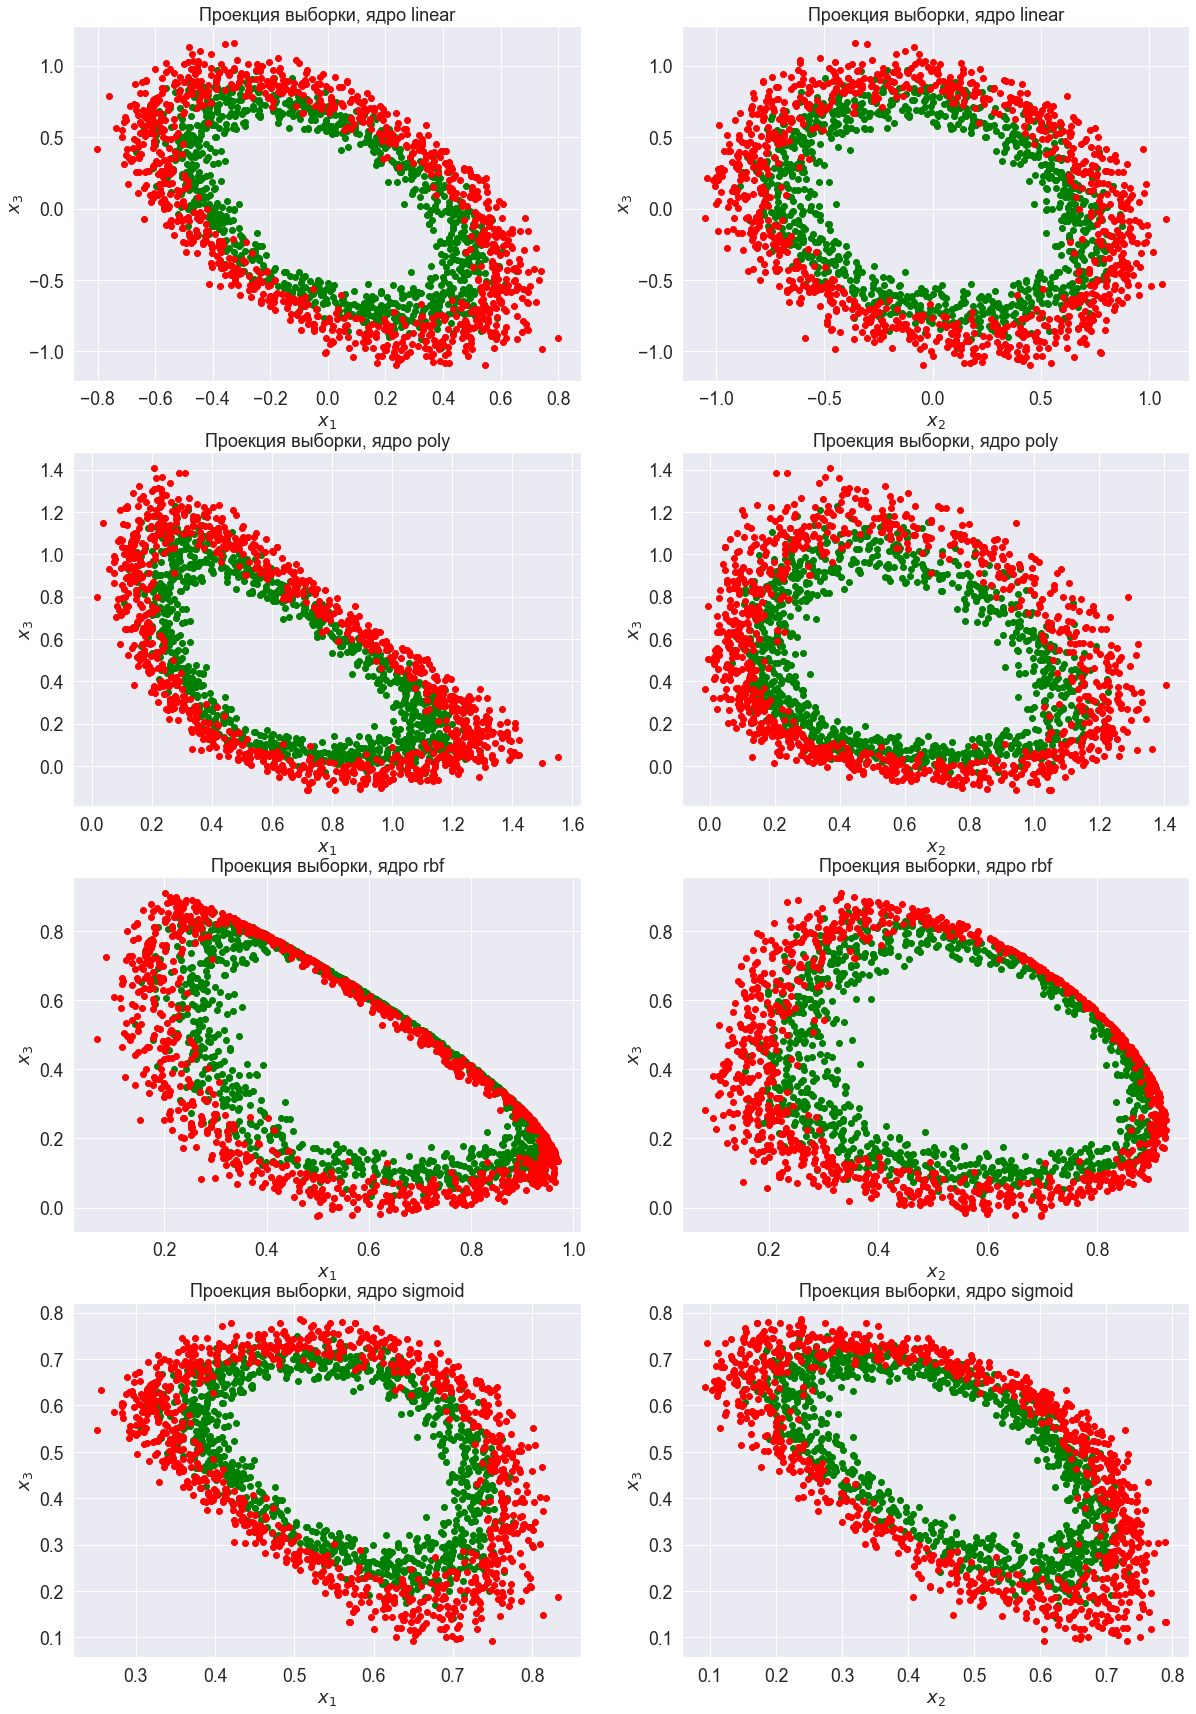

In [9]:
plt.figure(figsize=(20, 30))
cnt = 1
for ker in kernels:
    X_tricked = Nystroem(kernel=ker, gamma=0.2, random_state=322, n_components=3).fit_transform(X_circles)
    for i in range(2):
        plt.subplot(4, 2, cnt)
        cnt += 1
        plt.scatter(X_tricked[pos, i], X_tricked[pos, 2], c='g', label='Positive')
        plt.scatter(X_tricked[neg, i], X_tricked[neg, 2], c='r', label='Negative')
        plt.xlabel(f'$x_{i+1}$', fontsize=18)
        plt.ylabel('$x_3$', fontsize=18)
        plt.title(f'Проекция выборки, ядро {ker}', fontsize=18)
plt.show()

Видим, что на игрушечном примере с кругами наши хваленые умные ядра ничем не помогли. Это логично, все-таки мы используем эти методы не по назначению, выставляя очень странные параметры вроде n_components = 3 для удобства визуализации. \
Реабилитируем их на настоящих данных.

Для классификации будем использовать датасет из соревнования искусственных интеллектов в рамках [IJCNN 2001](https://www.ijcnn.org). Скачать его можно [здесь(ijcnn1)](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html)

In [10]:
df = load_svmlight_file("ijcnn1")
X, y = df[0], df[1]

In [11]:
seed = 322
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=seed)

In [12]:
len(y_train[y_train == 1]), len(y_train[y_train == -1])

(3382, 31611)

Выборка несбалансированная, учтем это и построим не только ROC-AUC, но и Precision-Recall curve.

In [13]:
pipeline = dict()
fit_time = dict()

In [14]:
for ker in tqdm(kernels):
    start = time.time()
    pipeline[ker] = make_pipeline(StandardScaler(with_mean=False), SVC(kernel=ker, probability=True))
    pipeline[ker].fit(X_train, y_train)
    finish = time.time()
    fit_time[ker] = finish - start

100%|██████████| 4/4 [08:14<00:00, 123.57s/it]


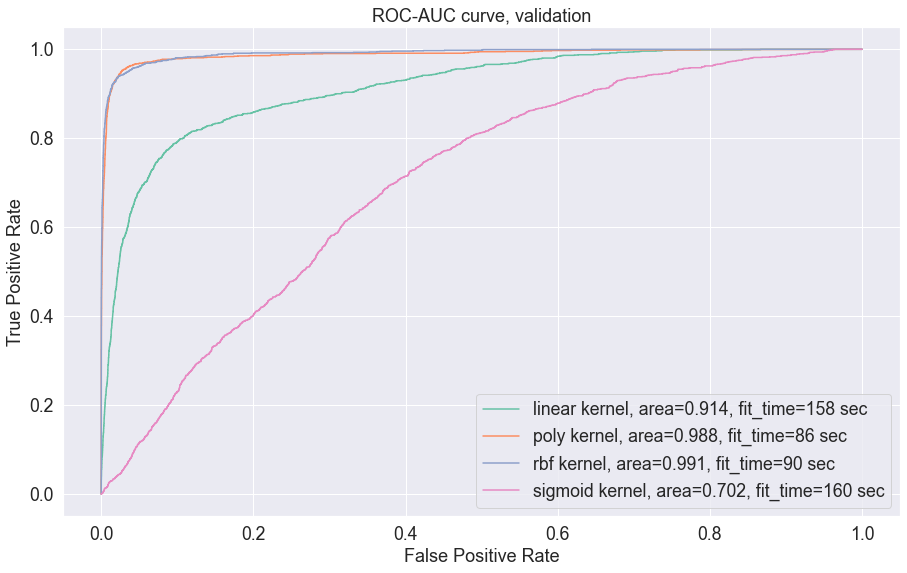

In [15]:
plt.figure(figsize=(15, 9))
for ker in kernels:
    pred = pipeline[ker].predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred[:, 1])
    plt.plot(fpr, tpr, label=f'{ker} kernel, area={round(metrics.auc(fpr, tpr), 3)}, fit_time={round(fit_time[ker])} sec')
plt.legend()
plt.title('ROC-AUC curve, validation', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.show()

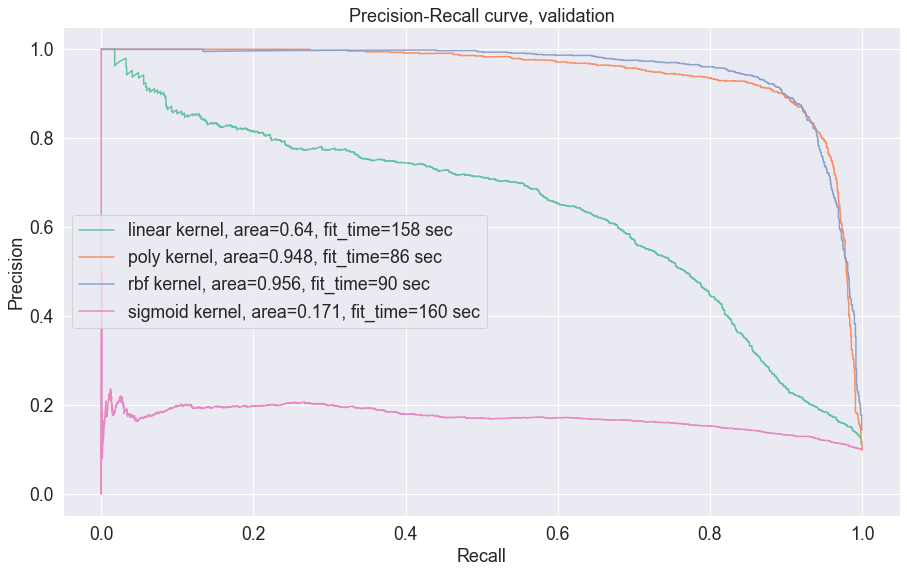

In [16]:
plt.figure(figsize=(15, 9))
for ker in kernels:
    pred = pipeline[ker].predict_proba(X_test)
    prec, rec, thresholds = precision_recall_curve(y_test, pred[:, 1])
    plt.plot(rec, prec, label=f'{ker} kernel, area={round(metrics.auc(rec, prec), 3)}, fit_time={round(fit_time[ker])} sec')
plt.legend()
plt.title('Precision-Recall curve, validation', fontsize=18)
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.show()

Linear - это фактически обычный SVM, который лучше всего применим при линейно разделимых входных данных. \
Видим, что на этом датасете sigmoid kernel потерпел фиаско по всем параметрам, и обучался долго, и результат отвратительный. \
Два других же нетривиальных ядра - полиномиальное и радиальное показали заметное улучшение в качестве относительно линейного, при этом обучались почти в 2 раза меньше.

Таким образом, грамотно подобранное ядро может значительно упростить нам жизнь, к сожалению в общем случае не очень понятно, как же подбирать

***Аппроксимация***
Ядерные методы используют уже не матрицу X, а матрицу $X^TX$. Соответственно, все операции вроде обращения требуют $\mathcal{O}(d^3)$ времени, что может стать узким местом алгоритма. Чтобы этого избежать, можно использовать новые признаки, которые по итогу дадут неплохое приближение ядер. Будем использовать Random Fourier Features(=Random Kitchen Sinks) Рассмотрим приближение гауссового ядра: \
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$. \
Остается вопрос, что взять за приближение $\sigma^2$. Выберем несмещенную оценку через медиану - 
$$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$ \
Так как выборка у нас может быть большой, то оценивать медиану мы будем через подвыборку размера порядка миллиона.

In [17]:
class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
    
    # флаг для последующих экспериментов
    def fit(self, X, y, mock_sigma2=False):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        if self.use_PCA:
            self.PCA = PCA(n_components=self.new_dim)
            X = self.PCA.fit_transform(X)
        else:
            self.new_dim = X.shape[1]
            
        ind1 = np.random.choice(len(X), 1000000)
        ind2 = (ind1 + 1 + np.random.choice(len(X) - 1, 1000000)) % len(X)
        
        sigma2 = np.median(np.sum(np.square((X[ind1] - X[ind2])), axis=1))
        if mock_sigma2:
            sigma2 *= 10000
        self.w = np.random.normal(0, 1/sigma2**0.5, size=(self.n_features, self.new_dim))
        self.b = np.random.uniform(-np.pi, np.pi, self.n_features)
        
        phi = np.cos(X @ self.w.T + self.b)
        
        if self.classifier == 'logreg':
            self.model = LogisticRegression().fit(phi, y)
        else:
            self.model = LinearSVC().fit(phi, y)
    
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA:
            X = self.PCA.transform(X)
        
        phi = np.cos(X @ self.w.T + self.b)
        return self.model.predict_proba(phi)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if self.use_PCA:
            X = self.PCA.transform(X)
        
        phi = np.cos(X @ self.w.T + self.b)
        return self.model.predict(phi)
    
    def trick(self, X):
        """
        Apply pipeline to obtain kernel tricked parameters for input data.
        """
        if self.use_PCA:
            X = self.PCA.transform(X)
        
        phi = np.cos(X @ self.w.T + self.b)
        return phi

In [18]:
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

In [19]:
for method in ['svm', 'logreg']:
    start = time.time()
    model = RFFPipeline(classifier=method)
    model.fit(x_train, y_train)
    end_train = time.time()
    print(f'Приближение ядер для случайных признаков, {method}')
    print("    Время обучения: {} сек".format(round(end_train - start, 3)))

    print("    Доля верных ответов на тесте: {}".format(accuracy_score(y_test, model.predict(x_test))))

    end_test = time.time()
    print("    Время применения: {} сек".format(round(end_test - end_train, 3)))

Приближение ядер для случайных признаков, svm
    Время обучения: 407.653 сек
    Доля верных ответов на тесте: 0.8715
    Время применения: 0.539 сек
Приближение ядер для случайных признаков, logreg
    Время обучения: 56.668 сек
    Доля верных ответов на тесте: 0.8574
    Время применения: 0.492 сек


In [20]:
for ker in kernels:
    start = time.time()

    # Отскейлим данные, чтобы было чуть-чуть побыстрее
    linear_svm = SVC(kernel=ker).fit(x_train / 255, y_train)
    end_train = time.time()
    print(f'SVM, {ker} ядро')
    print("    Время обучения: {} сек".format(round(end_train - start, 3)))

    print("    Доля верных ответов на тесте для {} SVM: {}".format(ker, accuracy_score(y_test, linear_svm.predict(x_test / 255))))
    end_test = time.time()
    print("    Время применения: {} сек".format(round(end_test - end_train, 3)))

SVM, linear ядро
    Время обучения: 437.908 сек
    Доля верных ответов на тесте для linear SVM: 0.8464
    Время применения: 100.387 сек
SVM, poly ядро
    Время обучения: 450.113 сек
    Доля верных ответов на тесте для poly SVM: 0.863
    Время применения: 128.024 сек
SVM, rbf ядро
    Время обучения: 356.735 сек
    Доля верных ответов на тесте для rbf SVM: 0.8828
    Время применения: 171.645 сек
SVM, sigmoid ядро
    Время обучения: 890.088 сек
    Доля верных ответов на тесте для sigmoid SVM: 0.4321
    Время применения: 224.317 сек


Снова sigmoid провалился, что поделать, не день Бекхема. \
Но нас интересует наше приближенное самописное ядро, посмотрим на него:
- Применяется моментально, что ожидаемо.
- LogReg обучается очень быстро, SVM с самописным ядром тоже быстрее чем linear и polynom.
- Результат прекрасный - accuracy не проседает по отношению к библиотечным методам.

Делаем вывод, что RFF отлично подходит для данной задачи. В общем случае конечно не так просто приблизить конкретное ядро, ведь уже вывести распределение на $w_j, b_j$ сложно с аналитической точки зрения.

***Общий вывод*** \
Рассмотрели несколько датасетов и убедились, что Kernel Trick позволяет улучшить перформанс. Sigmoid Kernel либо чувствителен к поставленной задаче, либо к подбору гиперпараметров, либо и к тому, и к тому. \
RFF показало себя великолепно, обучившись быстрее и показав один из лучших результатов. \
Применение Kernel Trick замедляет работу модели, поэтому всегда стоит подумать, а так ли оно нам надо, может можно обойтись более простыми методами.